In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [100]:
def save_states(states, filename):
    states_data = {
        'state': states,
        'sum': [sum(state) for state in states]
    }

    states_df = pd.DataFrame(states_data)
    display(states_df)
    states_df.to_csv(filename)

In [101]:
def merge_tiles(state):
    new_state = []
    # merging
    i = 0
    while i < len(state):
        if i < len(state) - 1 and state[i] == state[i+1]:
            new_state.append(state[i] * 2)
            i += 2
        else:
            new_state.append(state[i])
            i += 1
    return new_state

In [102]:
def generate_states():
    NEW_TILES = {2: 0.9, 4: 0.1}
    states = [[0], [2, 2], [2, 4], [4, 4]]
    def helper(cur_state, no_of_two, no_of_four):
        if cur_state[-1] == 2048:
            return
        else:
            # merge first
            merged_state = merge_tiles(cur_state)
            
            # generate a tile
            for value, prob in NEW_TILES.items():
                next_state = merged_state + [value]
                next_state.sort()
                
                if next_state not in states:
                    states.append(next_state)
                    helper(next_state)


    helper(states[1])
    helper(states[2])
    helper(states[3])

    return states

In [133]:
def generate_state_only_two():
    state = [2, 2]
    while (state[-1] != 2048):
        state = merge_tiles(state)
        state = state + [2]
        state.sort()
    return state

In [103]:
states = generate_states()

print(len(states))

3487


In [134]:
generate_state_only_two()

[2, 2, 8, 8, 2048]

In [104]:
# doing things on states
states.sort(key=sum)

save_states(states, "states.csv")

,state,sum
0,[0],0
1,"[2, 2]",4
2,"[2, 4]",6
3,"[4, 4]",8
4,"[2, 2, 4]",8
...,...,...
3482,"[2, 2, 16, 16, 2048]",2084
3483,"[4, 8, 8, 16, 1024, 1024]",2084
3484,"[2, 4, 8, 8, 16, 2048]",2086
3485,"[2, 4, 16, 16, 2048]",2086


In [105]:
# absorbing states
absorbing_states = [state for state in states if state[-1] == 2048]
print(len(absorbing_states))
save_states(absorbing_states, "absorbing_states.csv")



26


,state,sum
0,"[2, 4, 4, 8, 2048]",2066
1,"[2, 2, 8, 8, 2048]",2068
2,"[4, 4, 4, 8, 2048]",2068
3,"[2, 2, 16, 2048]",2068
4,"[2, 4, 8, 8, 2048]",2070
5,"[2, 4, 16, 2048]",2070
6,"[4, 4, 8, 8, 2048]",2072
7,"[4, 4, 16, 2048]",2072
8,"[2, 2, 4, 16, 2048]",2072
9,"[2, 4, 4, 16, 2048]",2074


In [106]:
# transient states
transient_states = [state for state in states if state[-1] != 2048]
print(len(transient_states))
save_states(transient_states, "transient_states.csv")

3461


,state,sum
0,[0],0
1,"[2, 2]",4
2,"[2, 4]",6
3,"[4, 4]",8
4,"[2, 2, 4]",8
...,...,...
3456,"[2, 2, 4, 8, 16, 1024, 1024]",2080
3457,"[4, 4, 8, 16, 512, 512, 1024]",2080
3458,"[2, 4, 4, 8, 16, 1024, 1024]",2082
3459,"[2, 8, 8, 16, 1024, 1024]",2082


In [107]:
def generate_transitions():
    NEW_TILES = {2: 0.9, 4: 0.1}
    transitions = np.zeros((len(states), len(states)))
    pre_initial_state = [0]
    next_states = {tuple(state): [] for state in states}

    # calculate transition probabilities for initial states
    for value0, prob0 in NEW_TILES.items():
        for value1, prob1 in NEW_TILES.items():
            initial_state = [value0, value1]
            initial_state.sort()

            if initial_state not in next_states[tuple(pre_initial_state)]:
                next_states[tuple(pre_initial_state)].append(initial_state)

            transitions[states.index(pre_initial_state)][states.index(initial_state)] += prob0 * prob1

    def helper():
        for cur_state in states:
            cur_state_idx = states.index(cur_state)
            if cur_state[-1] == 2048:
                transitions[cur_state_idx][cur_state_idx] = 1
            elif len(cur_state) == 1:
                continue
            else:
                # merge first
                merged_state = merge_tiles(cur_state)
                
                # generate a tile
                for value, prob in NEW_TILES.items():
                    next_state = merged_state + [value]
                    next_state.sort()
                    if next_state not in next_states[tuple(cur_state)]:
                        next_states[tuple(cur_state)].append(next_state)

                    cur_state_idx = states.index(cur_state)
                    next_state_idx = states.index(next_state)
                    transitions[cur_state_idx][next_state_idx] += prob
                    # print("Constructing from " + str(cur_state) + " to " + str(next_state)) 
                    # print("With probability = " + str(transitions[states.index(cur_state)][states.index(next_state)]))

    helper()
    return transitions, next_states


In [108]:
transitions,next_states = generate_transitions()

In [109]:
def make_transition_matrix(row_states, column_states):
    transition_matrix = np.zeros((len(row_states), len(column_states)))
    for cur_state in row_states:
        row_idx = row_states.index(cur_state)

        for next_state in next_states[tuple(cur_state)]:
            if next_state in column_states:
                # print("Transition from " + str(cur_state) + " to " + str(next_state))
                # print("With probability = " + str(transitions[states.index(cur_state)][states.index(next_state)]))
                column_idx = column_states.index(next_state)

                transition_matrix[row_idx][column_idx] = transitions[states.index(cur_state)][states.index(next_state)]
    return transition_matrix

In [110]:
def make_matrices():
    t = len(transient_states)
    r = len(absorbing_states)
    Q = make_transition_matrix(transient_states, transient_states)
    R = make_transition_matrix(transient_states, absorbing_states)
    I = np.identity(r)
    P = np.block([
        [Q, R], 
        [np.zeros((r, t)), I]])
    return t, r, Q, R, P

In [111]:
# matrix
t, r, Q, R, P = make_matrices()

In [112]:
# value in P
set([x for idx, x in np.ndenumerate(P)])

{0.0, 0.010000000000000002, 0.1, 0.18000000000000002, 0.81, 0.9, 1.0}

In [113]:
pd.DataFrame(transitions)

,0,1,2,3,4,5,6,7,8,9,...,3477,3478,3479,3480,3481,3482,3483,3484,3485,3486
0,0.0,0.81,0.18,0.01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.00,0.90,0.10,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.00,0.00,0.00,0.9,0.1,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.00,0.00,0.00,0.0,0.0,0.9,0.0,0.0,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.00,0.00,0.00,0.0,0.9,0.0,0.0,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3482,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3483,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9,0.1
3484,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3485,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


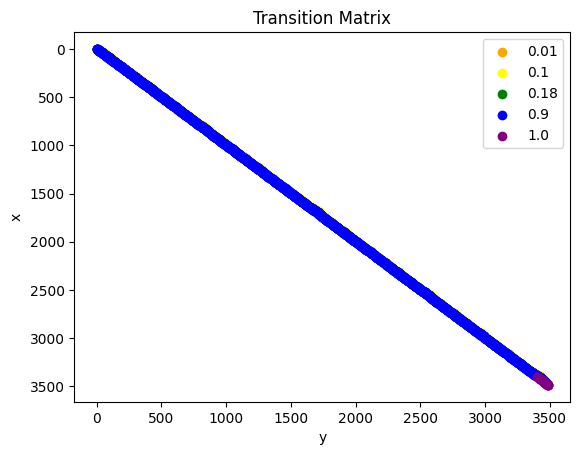

In [114]:
# plot transition matrix 
transitions_data = np.array([[idx[0], idx[1], val] for idx, val in np.ndenumerate(transitions)])
mapping= {0.01: "orange", 0.1: "yellow", 0.18: "green", 0.9: "blue", 1.0: "purple"}

for special_value in mapping:
    matching_points = transitions_data[abs(transitions_data[:,2]-special_value) <= 1e-6]
    plt.scatter(matching_points[:,1], matching_points[:,0], c=mapping[special_value], label=special_value)

plt.title("Transition Matrix")
plt.xlabel("y")
plt.ylabel("x")
plt.gca().invert_yaxis()
plt.legend()
plt.show()


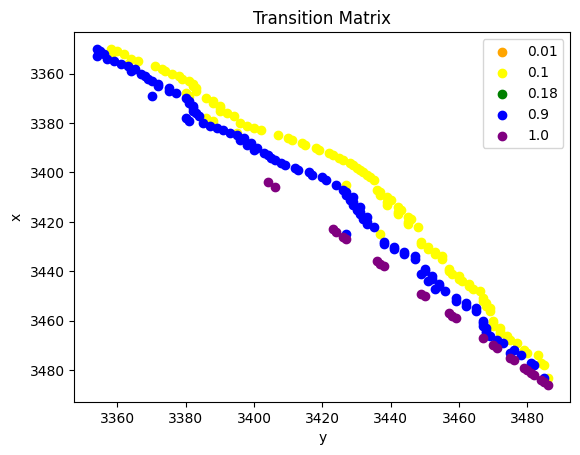

In [115]:
# plot transition matrix (zoomed in)
transitions_data = np.array([[idx[0], idx[1], val] for idx, val in np.ndenumerate(transitions) if idx[0] >= 3350 and idx[1] >= 3350])

for special_value in mapping:
    matching_points = transitions_data[abs(transitions_data[:,2]-special_value) <= 1e-6]
    plt.scatter(matching_points[:,1], matching_points[:,0], c=mapping[special_value], label=special_value)

plt.title("Transition Matrix")
plt.xlabel("y")
plt.ylabel("x")
plt.gca().invert_yaxis()
plt.legend()
plt.show()


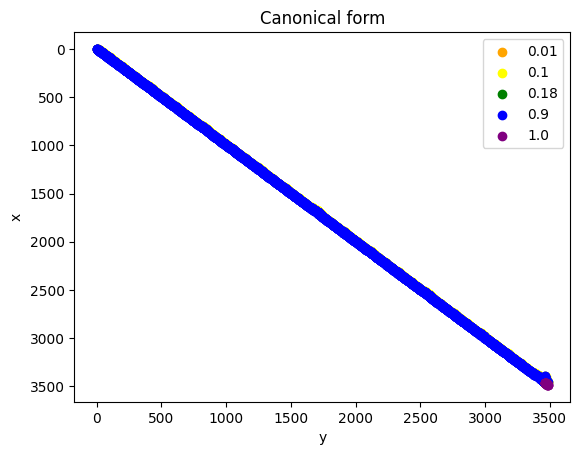

In [116]:
# plot canonical form
P_data = np.array([[idx[0], idx[1], val] for idx, val in np.ndenumerate(P)])

for special_value in mapping:
    matching_points = P_data[abs(P_data[:,2]-special_value) <= 1e-6]
    plt.scatter(matching_points[:,1], matching_points[:,0], c=mapping[special_value], label=special_value)

plt.title("Canonical form")
plt.xlabel("y")
plt.ylabel("x")
plt.gca().invert_yaxis()
plt.legend()
plt.show()


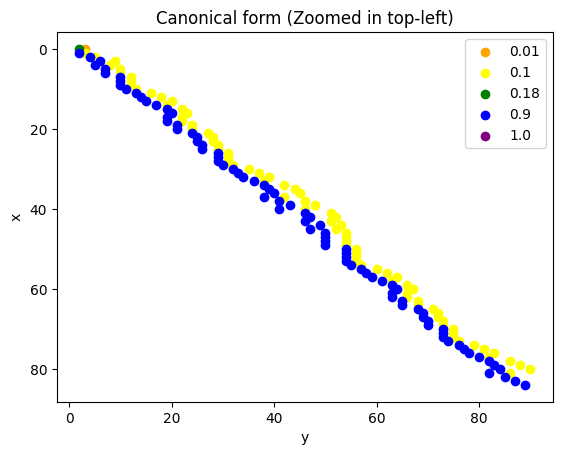

In [117]:
# plot canonical form (zoomed in to top-left)
P_zoom_in_data = np.array([[idx[0], idx[1], val] for idx, val in np.ndenumerate(P) if (idx[0] <= 90 and idx[1] <= 90)])

for special_value in mapping:
    matching_points = P_zoom_in_data[abs(P_zoom_in_data[:,2]-special_value) <= 1e-6]
    plt.scatter(matching_points[:,1], matching_points[:,0], c=mapping[special_value], label=special_value)
    #plt.plot(d[:,0], d[:,1], color=mapping[c][0], marker=mapping[c][1])

plt.title("Canonical form (Zoomed in top-left)")
plt.xlabel("y")
plt.ylabel("x")
plt.gca().invert_yaxis()
plt.legend()
plt.show()


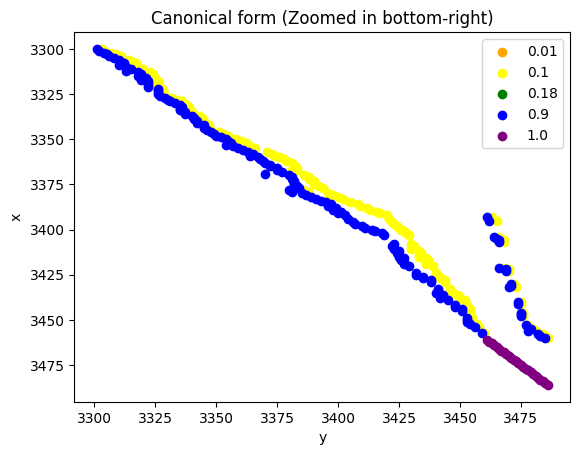

In [118]:
# plot canonical form (zoomed in to bottom-right)
P_zoom_in_data = np.array([[idx[0], idx[1], val] for idx, val in np.ndenumerate(P) if (idx[0] >= 3300 and idx[1] >= 3300)])

for special_value in mapping:
    matching_points = P_zoom_in_data[abs(P_zoom_in_data[:,2]-special_value) <= 1e-6]
    plt.scatter(matching_points[:,1], matching_points[:,0], c=mapping[special_value], label=special_value)
    #plt.plot(d[:,0], d[:,1], color=mapping[c][0], marker=mapping[c][1])

plt.title("Canonical form (Zoomed in bottom-right)")
plt.xlabel("y")
plt.ylabel("x")
plt.gca().invert_yaxis()
plt.legend()
plt.show()


In [119]:
# calculating expected moves
a = np.identity(t) - Q
b = np.array([1]*len(transient_states))
avg_moves_df = pd.DataFrame({
    'Average Moves': np.linalg.solve(a, b) ,
})
display(avg_moves_df)

,Average Moves
0,939.809917
1,938.991736
2,938.082645
3,937.173554
4,937.173554
...,...
3456,1.000000
3457,2.000000
3458,1.000000
3459,1.000000


In [120]:
# calculating absorbing probabilities matrix
a = np.identity(t) - Q
b = R
B = np.linalg.solve(a, b) 

absorbing_probability_matrix_df = pd.DataFrame(B)
display(absorbing_probability_matrix_df)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.03522,0.347896,0.003913,0.003913,0.076875,0.290978,0.004247,0.032283,0.141673,0.039535,...,0.000047,0.000006,0.000002,1.913818e-07,5.383636e-08,5.383636e-08,6.627273e-09,5.981818e-09,1.472727e-09,8.181818e-11
1,0.03522,0.347896,0.003913,0.003913,0.076875,0.290978,0.004247,0.032283,0.141673,0.039535,...,0.000047,0.000006,0.000002,1.913818e-07,5.383636e-08,5.383636e-08,6.627273e-09,5.981818e-09,1.472727e-09,8.181818e-11
2,0.03522,0.347896,0.003913,0.003913,0.076875,0.290978,0.004247,0.032283,0.141673,0.039535,...,0.000047,0.000006,0.000002,1.913818e-07,5.383636e-08,5.383636e-08,6.627273e-09,5.981818e-09,1.472727e-09,8.181818e-11
3,0.03522,0.347896,0.003913,0.003913,0.076875,0.290978,0.004247,0.032283,0.141673,0.039535,...,0.000047,0.000006,0.000002,1.913818e-07,5.383636e-08,5.383636e-08,6.627273e-09,5.981818e-09,1.472727e-09,8.181818e-11
4,0.03522,0.347896,0.003913,0.003913,0.076875,0.290978,0.004247,0.032283,0.141673,0.039535,...,0.000047,0.000006,0.000002,1.913818e-07,5.383636e-08,5.383636e-08,6.627273e-09,5.981818e-09,1.472727e-09,8.181818e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3456,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.900000,0.000000,0.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3457,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,8.100000e-01,0.000000e+00,1.800000e-01,1.000000e-02
3458,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,9.000000e-01,0.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00
3459,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e-01,0.000000e+00,1.000000e-01,0.000000e+00


In [121]:
# calculating absorbing probabilities
absorbing_probability_0 = {tuple(state): 0 for state in absorbing_states}
for idx, prob in np.ndenumerate(B[0]):
    absorbing_probability_0[tuple(absorbing_states[idx[0]])] += prob.item()

absorbing_probability_df = pd.DataFrame({
    "Absorbing State": [str(list(state)) for state in absorbing_probability_0.keys()],
    "Absorbing Probability": absorbing_probability_0.values(),
    "Sum": [sum(list(state)) for state in absorbing_probability_0.keys()],
})
display(absorbing_probability_df)

,Absorbing State,Absorbing Probability,Sum
0,"[2, 4, 4, 8, 2048]",3.522004e-02,2066
1,"[2, 2, 8, 8, 2048]",3.478958e-01,2068
2,"[4, 4, 4, 8, 2048]",3.913338e-03,2068
3,"[2, 2, 16, 2048]",3.913338e-03,2068
4,"[2, 4, 8, 8, 2048]",7.687536e-02,2070
5,"[2, 4, 16, 2048]",2.909784e-01,2070
6,"[4, 4, 8, 8, 2048]",4.246697e-03,2072
7,"[4, 4, 16, 2048]",3.228263e-02,2072
8,"[2, 2, 4, 16, 2048]",1.416725e-01,2072
9,"[2, 4, 4, 16, 2048]",3.953492e-02,2074


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

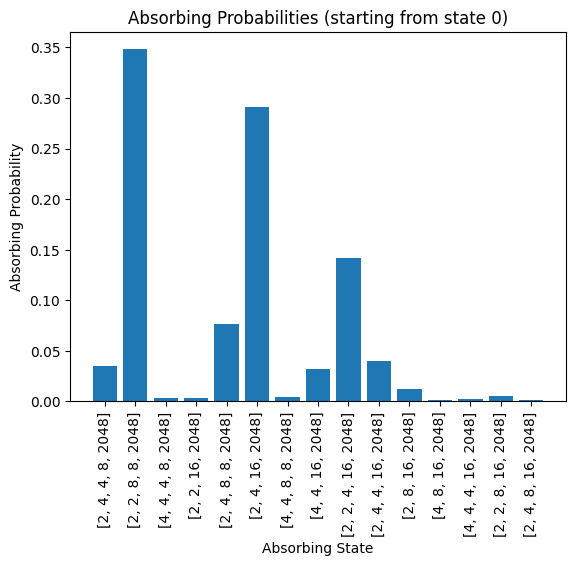

In [122]:
# plot absorbing probability (states)
sub_absorbing_probability_df = absorbing_probability_df[absorbing_probability_df['Absorbing Probability'] >= 1e-4]

fig, ax = plt.subplots()
plt.bar(sub_absorbing_probability_df['Absorbing State'], sub_absorbing_probability_df['Absorbing Probability'])
plt.title('Absorbing Probabilities (starting from state 0)')
plt.xlabel('Absorbing State')
plt.ylabel('Absorbing Probability')

plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

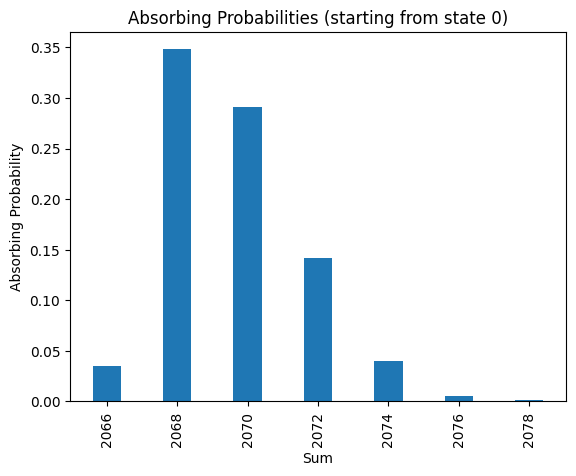

In [123]:
# plot absorbing probability (states)
sub_absorbing_probability_df = absorbing_probability_df[absorbing_probability_df['Absorbing Probability'] >= 1e-4]

fig, ax = plt.subplots()
plt.bar(sub_absorbing_probability_df['Sum'], sub_absorbing_probability_df['Absorbing Probability'])
plt.title('Absorbing Probabilities (starting from state 0)')
plt.xlabel('Sum')
plt.ylabel('Absorbing Probability')

plt.setp(ax.get_xticklabels(), fontsize=10, rotation='vertical')